# Introduction

In this Notebook, you will learn that
1. logistic regression with reguralisation is equivalent to MAP
2. the MAP point estimate may be very different from the posterior mean in high dimensions and why the probability returned by general recipe logistic regression (`sklearn`) is not a useful measure of uncertainty.


## Logistic regression as MAP

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

As an optimization problem, binary class $\ell_2$ penalized logistic regression minimizes the following cost function:

$$
\min_{w, c} \frac{w^T w}{2 } + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .
$$

where $y_i\in\{-1,1\}$ is the class variable (instead of denoting class as $\{0,1\}$ for convenience $\{-1,1\}$
is used in the above formula, that is the class $0$ is represented as $-1$). $w$ are the weights (slopes) and $c$ is the intercept, while $C\geq0$ is the reguralization constant.

The above minimization problem can equivalently be written as

$$
\max_{w, c} -\frac{w^T w}{2 C}-  \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) 
$$
that is the solution $w, c$ is the same as the above problem, or, equivalently, by exponentiating as

$$
\max_{w, c} e^{-\frac{w^T w}{2 C}}\prod_{i=1}^n \frac{1}{e^{- y_i (X_i^T w + c))}+1}
$$

By expressing the class variable as $\{0,1\}$, the above maximization problem is also equivalent to

$$
\max_{w, c} e^{-\frac{w^T w}{2 C}}\prod_{i=1}^n \Phi(X_i^T w + c)^{y_i} (1-\Phi(X_i^T w + c))^{1-y_i}
$$
with
$$
\Phi(X_i^T w + c)=\frac{1}{e^{- (X_i^T w + c)}+1}
$$

If we use our notation denoting $w$ with $\beta$ and $c$ with $\alpha$, we have
$$
\max_{\beta, \alpha} e^{-\frac{\beta^T \beta}{2 C}}\prod_{i=1}^n \Phi(X_i^T \beta + \alpha)^{y_i} (1-\Phi(X_i^T  \beta + \alpha)^{1-y_i}
$$
which is also equivalent to
$$
\max_{\beta, \alpha} \left(\frac{1}{\sqrt{2\pi C}}\right)^b e^{-\frac{\beta^T \beta}{2 C}}\prod_{i=1}^n \Phi(X_i^T \beta + \alpha)^{y_i} (1-\Phi(X_i^T  \beta + \alpha)^{1-y_i}
$$
where $b$ is the length of $\beta$, that is the number of features (columns of the data matrix $X$),
in fact multiplying by a positive constant that does not depend on the optimization variables $\alpha,\beta$
does not change the maximum.
 
Therefore we have showed that the above **maximization problem is a MAP estimator** for the following probabilistic model:

**Likelihood**
$$
p(data|\beta , \alpha)=\prod_{i=1}^n \Phi(X_i^T \beta + \alpha)^{y_i} (1-\Phi(X_i^T  \beta + \alpha)^{1-y_i}
$$

**Prior**
$$
p(\beta)= \left(\tfrac{1}{\sqrt{2\pi \sigma^2}}\right)^b e^{-\frac{\beta^T \beta}{2 \sigma^2}}
$$
with $C=\sigma^2$.

and
$$
p(\alpha)= \left(\tfrac{1}{\sqrt{2\pi r}}\right) e^{-\frac{\alpha^2}{2 r}}
$$
with $r$ very very large, so that $p(\alpha)$ is very small and has not effect on the maximization.

We will also verify that in the following problem by showing that the solution that `sklearn` returns is the same as the MAP problem solved via PyMC3 for the probabilistic model above (apart from small numerical differences).

# Loading data
We will use the Titanic dataset from the Kaggle competition https://www.kaggle.com/c/titanic. The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In [395]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #To evaluate our model
from sklearn.metrics import roc_curve
import re as re
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression


train = pd.read_csv('../datasets/titanic.csv', header = 0, dtype={'Age': np.float64})
original_test  = pd.read_csv('../datasets/titanic_test.csv' , header = 0, dtype={'Age': np.float64})
test = original_test.copy(deep=True)
full_data = [train, test]

train.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preparing data for resolution

In this notebook, we will not get into the details of feature engineering. We will make some classic processing on the features. There may be several feature optimization that could still be done, but it is not the purpose of this notebook.

### Family size categories
Let's create LargeFamily (2 classes: 1 to 4, 5 and up)

In [396]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['LargeFamily'] = dataset['FamilySize'].apply(lambda r: 0 if r<=4 else 1)



## Names ##
inside this feature we can find the title of people.

In [397]:
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


 so we have titles. let's categorize it and check the title impact on survival rate.

In [398]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


# Other data
Now let's clean all other fields and map our features into numerical values.

   Survived  Pclass  Sex  Age  Fare  Embarked  LargeFamily  Title
0         0       3    1    1     0         0            0      1
1         1       1    0    2     3         1            0      3
2         1       3    0    1     1         0            0      2
3         1       1    0    2     3         0            0      3
4         0       3    1    2     1         0            0      1
5         0       3    1    1     1         2            0      1
6         0       1    1    3     3         0            0      1
7         0       3    1    0     2         0            1      4
8         1       3    0    1     1         0            0      3
9         1       2    0    0     2         1            0      3


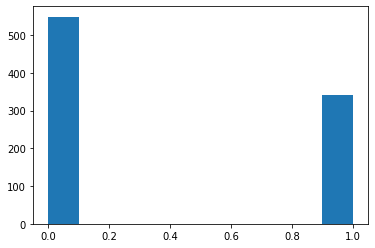

In [399]:
np.random.seed(42)
for dataset in full_data:   
    # Fill missing values in Embarked with most frequent port 'S'
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
    # Fill missing values in Fare with median
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

    # Fill missing values in age with random data based on mean and standard variation
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count, )
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
        
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4
    
# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))
plt.hist(train.values[0::, 0]);#class balance

Good! now we have a clean dataset.

##  Logistic polynomial regression ##

We consider a logistic polynomial regression with up to degree 2 polynomial features.

 - C=1/0.0001: the regularization term
 - d=2: the degree of the polynomial combination of features
 
 these parameters have been selected via grid-search cross-validation

In [401]:
X = train.values[0::, 1::]
y = train.values[0::, 0]

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0       )


# Create polynomial features
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.fit_transform(X_test)

#Scaling
scaler = StandardScaler()
X_train_n=X_train_poly.copy()
X_test_n=X_train_poly.copy()
scaler.fit(X_train_poly)
X_train_n=scaler.transform(X_train_poly)
X_test_n=scaler.transform(X_test_poly)

regurC=1000#reguralisation constant
clf = LogisticRegression(max_iter=3000,C=regurC, solver='lbfgs')        
clf.fit(X_train_n, y_train)
y_pred_LR = clf.predict(X_test_n)
y_pred_prob_LR = clf.predict_proba(X_test_n)[:,1]
print("Testing accuracy: ")
print(accuracy_score(y_test,y_pred_LR))
print("\n")
print(confusion_matrix(y_test, y_pred_LR))

Testing accuracy: 
0.8283582089552238


[[151  17]
 [ 29  71]]


We will now compute the distribution of the probability of class 1 for the instances in the test set that where wrongly classified
and for the instances that were correctly classified.

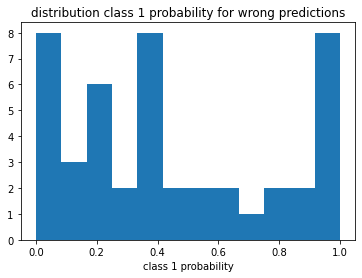

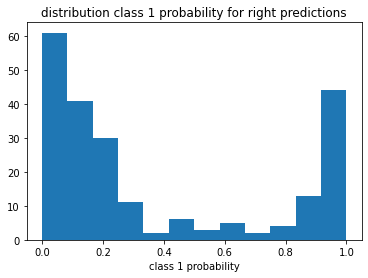

In [402]:
threshold=0.5
y_pred_LR=np.where(y_pred_prob_LR>threshold,1,0)
plt.figure()
ind_decision_class1=np.where(y_test!=y_pred_LR)[0]
plt.hist(y_pred_prob_LR[ind_decision_class1],bins=12);
plt.title("distribution class 1 probability for wrong predictions")
plt.xlabel("class 1 probability")

plt.figure()
plt.title("distribution class 1 probability for right predictions")
plt.xlabel("class 1 probability")
ind_decision_class1=np.where(y_test==y_pred_LR)[0]
plt.hist(y_pred_prob_LR[ind_decision_class1],bins=12);

From the first plot, you can notice that logistic regression makes quite a lot of mistakes in the instances that were
classified with high (close to 1) or low (close to 0) probability.
Instead we would have expected to see the maximum number of mistakes in the instances that were classified with probability close to 0.5. **This intuition is wrong. In a classification problem, the logistic classifier gives you a probability value for each class, but this is not the same as uncertainty we compute in probabilistic Machine Learning. This probability is the probability that an input is a given class relative to the other classes. Because the probability is relative to the other classes, it does not help explain the model's overall confidence on its own predictions.**

We need to compute the posterior to have the full picture.

In [403]:
import pymc3 as pm
#be sure that the
with pm.Model() as logistic_model:     
    alpha= pm.Normal('alpha', 0.0, sd=100000)
    beta = pm.Normal('beta', 0.0, sd=np.sqrt(regurC), shape=(X_train_n.shape[1],)) #
    phi = pm.Deterministic('phi', pm.math.invlogit(alpha+pm.math.dot(X_train_n, beta)))#logistic function 
    #tt.printing.Print('alpha_ls')(phi)
    likelihood = pm.Bernoulli('likelihood', phi, observed=y_train)

#We COMPUTE THE MAP here
with logistic_model:
    est_theta=pm.find_MAP(maxeval=15000, method="l-bfgs-b")

logp = -736.43, ||grad|| = 0.047296: 100%|██████████| 2179/2179 [00:01<00:00, 1827.59it/s] 


In [404]:
X_train_n.shape

(623, 120)

## Compare sklearn vs MAP
You can notice that the slopes and intercepts returned by `sklearn` coincide with MAP estimate computed by PyMC3 (apart from numerical differences)

In [405]:
np.set_printoptions(suppress=True)
print("Pymc3 MAP")
print(est_theta['beta'])
print(est_theta['alpha'],"\n")
print("Sklearn reguralised logistic regression")
print(clf.coef_[0,:])
print(clf.intercept_[0])

Pymc3 MAP
[  0.           8.77427565  -5.03934521   7.08725506  20.90655439
 -15.06694672   0.20364833  -2.13020876  -1.34597425  -4.3815136
  -7.18705473 -25.36785974  14.35606761  -1.17501389   9.5938773
  -5.03934521  12.14222584   3.61022121   6.18563452  -1.96359046
   8.06555399  -9.87424014  -9.5624732   -1.56596209  -0.38427125
   3.34546087 -24.71761896  15.0108335    0.37994068   9.37852988
  -2.17963073  -0.04245291   5.39753996   0.20364833   0.97707674
  -5.86325388  -9.38836711  12.95526686   6.91352146   7.75250271
  -5.48713369  -2.06144697   0.93412351  -4.3815136  -13.89763077
  -1.79848603  -1.45251491  -1.98148368   7.70481099   8.62432813
   6.23769465  -2.37349006  -1.97581615 -14.02432306   9.99089464
  -1.25680745  -0.69325524  -0.72894888   6.75868094  -0.04245291
  -6.21042722  -1.17501389  -0.37074237   1.1550525   -5.03934521
  12.14222584   3.61022121   6.18563452  -1.96359046   8.06555399
  -8.92412496  -8.51865312   0.80064651  -0.09596061  -2.12439211
  

We now compute the samples from the full posterior using advi approximation to speed-up the computation.

Average Loss = 847.14: 100%|██████████| 100000/100000 [00:38<00:00, 2593.49it/s]
Finished [100%]: Average Loss = 847.12


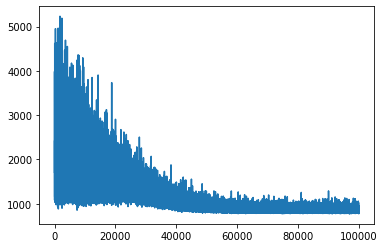

In [406]:
with logistic_model:
    approximation = pm.fit(100000,method='advi')#50000 are the number of iterations of the algorithms
    
plt.plot(approximation.hist);
posterior = approximation.sample(5000)#we sample 500000 samples from the posterior

    

You can notice below how the posterior mean is totally different from the MAP (and sklearn) estimate. In high dimensions
(X has 36 columns), the posterior mean can be very far from the MAP estimate. The posterior mean changes depending 
on the shape of the distribution. In logistic classification, the posterior is not symmetric and, therefore, the posterior mean is very far from its maximum (MAP estimate).

In [407]:
print("Pymc3 posterior mean of the parameters")
print(np.mean(posterior['beta'],axis=0))
print(np.mean(posterior['alpha']))
print("Sklearn reguralised logistic regression")
print(clf.coef_[0,:])
print(clf.intercept_[0])

Pymc3 posterior mean of the parameters
[ 0.24888565 -1.74120484 -1.59212159  0.73883247 -1.01289413  0.19863995
  0.13517177 -0.21238706 -1.14149109  0.74027798 -0.46948217 -1.11127541
 -0.12232387 -0.63674308 -0.20006831 -1.585946    0.26064764  0.38984168
  0.1413274  -1.32944876 -0.37917961  0.10762054  0.15926311  0.39093136
 -0.02484141 -0.24036802 -1.13782218  0.33996243  0.23945268  0.38889308
 -0.05827716 -1.94791361  0.09542778  0.15084335  0.33701488 -0.40947933
 -0.65273147  1.95836209 -0.21189566  1.33049056  1.02027658 -1.03600707
  1.07408769  0.74412517  0.03190252  0.11568919 -0.14684498 -1.05832203
  0.56448785 -0.13509143 -0.35201508  0.41738845 -0.86130234 -0.28009228
 -0.38492221 -0.25218254 -0.41159459  0.63937611  0.13856491 -1.98163431
  0.27014026 -0.6222297  -0.47365047  0.30452074 -1.5897788   0.26041437
  0.39077876  0.13910089 -1.36693534 -0.38082333  0.15662884  0.4606413
 -0.0159471  -0.6774988  -1.19039693 -0.00027496  0.05179983 -1.35188729
  1.32791081 

We will see now that although the MAP and posterior mean are different, the accuracy of the two models is similar. However, we do not only care about accuracy, but we want to know the reliability of our predictions. 

In [408]:
#sampled probability of class 1
y_pred_proba_Bayes_samples = 1/(1+np.exp(-posterior['alpha'].T-np.dot(X_test_n,posterior['beta'].T)))#proba class 1
#mean of the samples probablities
y_pred_proba_Bayes=np.mean(y_pred_proba_Bayes_samples,axis=1)
threshold=0.5
#class predicted
y_pred_B=np.where(y_pred_proba_Bayes>threshold,1,0)
print("Testing accuracy: ")
print(accuracy_score(y_test,y_pred_B))

Testing accuracy: 
0.8134328358208955


We should also check the uncertainty provided by the posterior. Each sampled probability `y_pred_proba_Bayes_samples` determines a prediction, class 0 and class 1. A way
to evaluate the uncertainty on the prediction for a certain instance in the test set is to compute
the standard deviation of these different predictions.
If the standard deviation is small, then it means that the decision was always class 0 (or class 1), while if the standard deviation  is high it means that the probabilistic classifier is undecided about how to classify that instance. 

In [409]:
y_pred_samples=np.where(y_pred_proba_Bayes_samples>threshold,1,0)
uncertainty=np.std(y_pred_samples,axis=1)

We can plot this uncertainty against the mean predicted probability as follows:

Text(0, 0.5, 'STD of the predicted class')

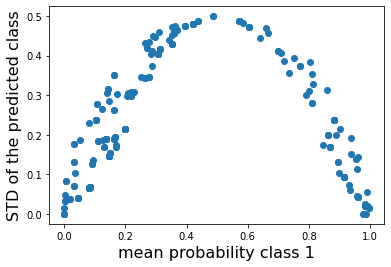

In [414]:
plt.scatter(y_pred_proba_Bayes,uncertainty)
ind_wrong=np.where(y_test!=y_pred_B)[0]
plt.xlabel("mean probability class 1", fontsize=16)
plt.ylabel("STD of the predicted class", fontsize=16)

This scatter plot is what we should expect, the Bayesian logistic classifier is more uncertainty
in the instances that have posterior mean close to $0.5$. Instead what about the 
MAP estimated returned by `sklearn`

Text(0, 0.5, 'STD of the predicted class')

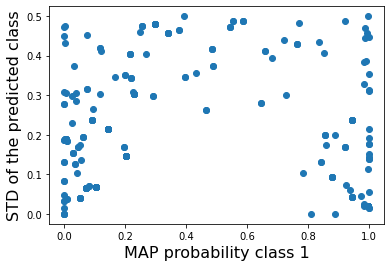

In [411]:
plt.scatter(y_pred_prob_LR,uncertainty)
plt.xlabel("MAP probability class 1", fontsize=16)
plt.ylabel("STD of the predicted class", fontsize=16)

The above plot shows that the probability returned by the MAP estimate can be very high even for instances that have high uncertainty.  This shows that we should not use the probability
computed by the logistic classifier as a measure of uncertainty: they can be close to $0$ or $1$ but those instances  could be very uncertain. The posterior mean is a better point estimate of the MAP (and so `sklearn` point estimate) because it accounts for the uncertainty.

Text(0, 0.5, 'STD of the predicted class')

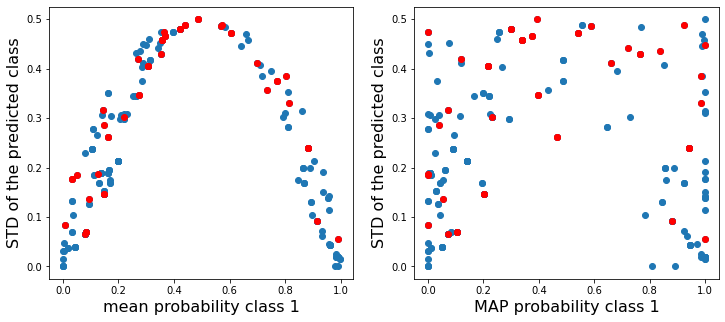

In [418]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(y_pred_proba_Bayes,uncertainty)
ind_wrong=np.where(y_test!=y_pred_B)[0]
plt.scatter(y_pred_proba_Bayes[ind_wrong],uncertainty[ind_wrong],color='r')
plt.xlabel("mean probability class 1", fontsize=16)
plt.ylabel("STD of the predicted class", fontsize=16)
plt.subplot(122)
plt.scatter(y_pred_prob_LR,uncertainty)
ind_wrong=np.where(y_test!=y_pred_LR)[0]
plt.scatter(y_pred_prob_LR[ind_wrong],uncertainty[ind_wrong],color='r')
plt.xlabel("MAP probability class 1", fontsize=16)
plt.ylabel("STD of the predicted class", fontsize=16)

In the above plots, we have reported the previous two plots, but we have colored the wrongly classified instances by the two models in red. From the left plot, you can see that the Bayesian classifier makes the majority of the mistakes in instances that were estimated to have high uncertainty and posterior mean close to $0.5$, while the MAP-based classifier (Sklearn) makes several mistakes in instances that have probability closer to $0$ or $1$. 